# Create model
 Performs hiperparameter search and then train model with results obtained

## Load libraries 
Install & load python libraries

In [ ]:
pip install tabgan==1.3.3 #9500 secs

In [ ]:
!pip install lightgbm

In [ ]:
pip install --upgrade pandas "dask[complete]"

In [4]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
#from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
#from scikitplot.metrics import plot_lift_curve
#from scikitplot.helpers import binary_ks_curve 
#from scikitplot.metrics import plot_ks_statistic
#from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.memory_usage', True)

## Load data 
Load train & test data from parquet file previously saved <br>
Define limpiar_nombres_columnas & nombres_de_columnas <br>
Define input variables for model <br>

In [6]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model"
df1Train = pd.read_parquet(f"s3://{s3_url}/TargetTodos/Train/Train.parquet")
tg1Train = df1Train['target']

df1Val = pd.read_parquet(f"s3://{s3_url}/TargetTodos/Validation/Validation.parquet")
tg1Val = df1Val['target']


In [7]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
df1Train = limpiar_nombres_columnas(df1Train)
df1Val = limpiar_nombres_columnas(df1Val)

In [8]:
#listar las columnas del dataframe

def nombres_de_columnas(dataframe):
    return dataframe.columns.tolist()

# Supongamos que tu DataFrame se llama 'df'
# Puedes ajustar el nombre según el que hayas utilizado

nombres_columnas = nombres_de_columnas(df1Train)

# Imprimir los nombres de las columnas
print(f'Nombres de columnas: {nombres_columnas}')


Nombres de columnas: ['id_branch', 'id_receiver', 'date_receiver', 'id_location', 'id_payer', 'id_sender_global', 'net_amount_receiver', 'receiver_transaction_count', 'receiver_date_first_transaction', 'receiver_date_last_transaction', 'id_country_receiver_claim', 'id_state_receiver_claim', 'id_state', 'branch_working_days', 'sender_sending_days', 'sender_days_to_last_transaction', 'id_country', 'fraud_classification', 'sender_minutes_since_last_transaction', 'sender_days_since_last_transaction', 'branch_trans_3m', 'count_date_receiver_distinct', 'sender_state', 'branch_has_fraud', 'fecha_last_fraud_branch', 'receiver_has_fraud', 'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_4min', 'location_nro_fraud', 'sender_trans_3m', 'range_hist', 'sender_nro_fraud', 'mes', 'hour_receiver', '01_isMexico', '01_sender_branch_state', '01_Var_range_hist', '01_receiver_fraud', '01_branch_fraud', '01_location_fraud', '01_sender_fraud', '01_isCashPick', '01_isBankDep', 'sender_days_to_last_tr

#variables 1er modelo
var_input = ['01_receiver_transaction_count', '01_sender_sending_days', '01_branch_working_days', '01_net_amount_receiver', 
         '01_sender_minutes_since_last_transaction_2days', '01_sender_minutes_since_last_transaction_1day', 
         '01_sender_days_to_last_transaction_365', 'day_name_receiver_Friday', 'day_name_receiver_Monday', 
         'day_name_receiver_Saturday', 'day_name_receiver_Sunday', 'day_name_receiver_Thursday', 'day_name_receiver_Tuesday', 
         'day_name_receiver_Wednesday','id_payout_A', 'id_payout_C', 'id_payout_D', 'id_payout_M', 'id_payout_N', 'id_payout_O', 
         'id_payout_P', 'id_payout_S', 'id_payout_T', 'id_payout_X',
         '01_isMexico','tx_brancity', 'tx_brancity_total', 'ptx_brancity','idlocation_fraud']

In [9]:
var_input = [ 'branch_trans_3m', 'count_date_receiver_distinct','branch_has_fraud',
       'receiver_has_fraud',
       'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_4min',
       'location_nro_fraud', 'sender_trans_3m',
       'sender_nro_fraud', '01_isMexico',
       '01_sender_branch_state', '01_Var_range_hist', '01_receiver_fraud',
       '01_branch_fraud', '01_location_fraud', '01_sender_fraud',
       '01_isCashPick', '01_isBankDep',
       'sender_days_to_last_transaction_more7m',
       '01_receiver_transaction_count', '01_sender_sending_days',
       '01_branch_working_days', '01_net_amount_receiver',
       '01_sender_minutes_since_last_transaction_2days',
       '01_sender_days_to_last_transaction_365',
       '01_sender_days_to_last_transaction_7m', '01_hour_receiver']
#, 'id_payout_A', 'id_payout_C', 'id_payout_D',
#       'id_payout_M', 'id_payout_N', 'id_payout_O', 'id_payout_P',
#       'id_payout_S', 'id_payout_T', 'id_payout_X'
# 'id_state', 'sender_state', 

In [10]:
#Ya lo traje dividido en conjuntos de entrenamiento (70%) y prueba (30%)

X_train = df1Train[var_input]
X_test = df1Val[var_input] 
y_train =  pd.DataFrame(df1Train['target']) 
y_test = pd.DataFrame(df1Val['target']) 

#Uni test y Val
X = pd.concat([df1Train[var_input], df1Val[var_input]], ignore_index=True) 
Y = pd.DataFrame(pd.concat([df1Train['target'], df1Val['target']], ignore_index=True)) 


In [11]:
def calcular_porcentaje_valor_1(columna):
    """
    Calcula el porcentaje de ocurrencia del valor 1 en una columna dicotómica.

    Parameters:
    - columna: Columna con valores binarios (0 o 1).

    Returns:
    - Porcentaje de ocurrencia del valor 1.
    """

    total_registros = len(columna)
    ocurrencias_valor_1 = columna.sum()

    porcentaje_valor_1 = (ocurrencias_valor_1 / total_registros) * 100

    return porcentaje_valor_1
porcentaje_1 = calcular_porcentaje_valor_1(Y['target'])
porcentaje_1

0.0035575621933620553

## Training

In [12]:
# Dividir el conjunto de datos en conjuntos de entrenamiento (80%) y prueba (20%)
# X_train: características de entrenamiento, X_test: características de prueba
# y_train: etiquetas de entrenamiento, y_test: etiquetas de prueba
# Se utiliza un 20% de los datos para prueba, y se fija la semilla aleatoria en 88 para reproducibilidad.

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 88) 

In [13]:
fit_parameters = {
    #"early_stopping_rounds": 30,           # Number of rounds to stop train when there is no more improvement
    "eval_metric": 'logloss',              # Metric for evaluation
    "eval_set": [(X_test, y_test)],        # Dataset for evaluation during training
    'eval_names': ['valid'],               # Name for validation set
    #'verbose': 100,                        # Log level of output during training
}

In [14]:
# Parameters for hiperparamenter search (RandomizedSearchCV)
param_testeo = {
    "n_estimators": [5, 10, 15, 20, 25, 30, 35, 50, 100, 150, 300, 400, 500, 510, 520],
    # Number of estimatores (trees) to fit

    "num_leaves": [2, 3, 4, 6, 10, 20, 25, 28, 30, 31, 32, 33, 35, 40, 45],
    # Maximun number of node leaves

    "max_depth": [10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 35, 100, 125, 150, 170, 200, 250, 300, 400],
    # Maximun tree depth

    "colsample_bytree": [0.50, 0.55, 0.6, 0.65, 0.68, 0.70, 0.71, 0.80, 0.81, 0.84, 0.85, 0.86, 0.9],
    # Subsample ratio of columns when constructing each tree

    "min_child_weight": [0.001, 0.002, 0.0025, 0.0026, 0.0027, 0.003, 0.004, 0.005, 0.007, 0.008, 0.009],
    # Minimun weight necessary to create new node 

    "learning_rate": [0.1, 0.02, 0.03, 0.04, 0.07, 0.005, 0.003, 0.001],
    # Learning rate of model

    'subsample': [1],
    # Percentage of rows used per tree building operation

    "objective": ['binary'],
    # Problem to solve. Binary classification in this case

    "importance_type": ["gini", "entropy"],
    # Importante type for characteristics

    "boosting_type": ["dart", "goss", "rf", "gbdt"],
    # boosting type to evaluate
    
    #"is_unbalance": ['True'],

    "scale_pos_weight" : [0.002, 0.003, 0.004] ,
    
    "force_col_wise" : ['True'],
}


{'subsample': 1,
 'scale_pos_weight': 0.002,
 'objective': 'binary',
 'num_leaves': 30,
 'n_estimators': 500,
 'min_child_weight': 0.0027,
 'max_depth': 25,
 'learning_rate': 0.07,
 'importance_type': 'gini',
 'colsample_bytree': 0.65,
 'boosting_type': 'gbdt'}

In [15]:
# Parameters for hiperparamenter search (RandomizedSearchCV) restricted to the first result obtained
param_testeoB = {
    "n_estimators": [460, 480, 400,  500, 510, 520, 530],
    # Number of estimatores (trees) to fit

    "num_leaves": [ 25, 26, 28, 30, 32, 34, 35],
    # Maximun number of node leaves

    "max_depth": [ 17, 18, 19, 20, 21, 22, 23],
    # Maximun tree depth

    "colsample_bytree": [ 0.82 ,0.83, 0.84, 0.86, 0.87],
    # Subsample ratio of columns when constructing each tree

    "min_child_weight": [ 0.0025, 0.0026, 0.0027, 0.0031, 0.0033 ],
    # Minimun weight necessary to create new node 

    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09],
    # Learning rate of model

    'subsample': [1],
    # Percentage of rows used per tree building operation

    "objective": ['binary'],
    # Problem to solve. Binary classification in this case

    "importance_type": ["gini", "entropy"],
    # Importante type for characteristics

    "boosting_type": ["dart", "goss", "rf", "gbdt"],
    # boosting type to evaluate
    
    #"is_unbalance": ['True'],

    "scale_pos_weight" : [0.002, 0.003, 0.004] ,
    
    "force_col_wise" : ['True'],
}


In [17]:
# This parameter defines the number of hiperparameters points to be tested
n_HP_points_to_test = 100


In [18]:
def entrenar_modelo_con_busqueda_aleatoria(X, Y, fit_parameters, param_testeo, n_HP_points_to_test=100, random_state=87):
    """
    Entrena un modelo utilizando LightGBM con búsqueda aleatoria de hiperparámetros.

    Parameters:
    - X: Características del conjunto de datos.
    - Y: Etiquetas del conjunto de datos.
    - fit_parameters: Parámetros para el entrenamiento y evaluación del modelo.
    - param_testeo: Parámetros para la búsqueda aleatoria de hiperparámetros.
    - n_HP_points_to_test: Número de combinaciones de hiperparámetros a probar (predeterminado: 100).
    - random_state: Semilla aleatoria para reproducibilidad (predeterminado: 87).

    Returns:
    - Objeto de resultados de RandomizedSearchCV.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

    # Clean column names calling function limpiar_nombres_columnas
    X_train = limpiar_nombres_columnas(X_train)
    X_test = limpiar_nombres_columnas(X_test)

    # Create clasifier LightGBM and perform parametric search of hyperparameters
    lgbm = LGBMClassifier(random_state=random_state)
    result_trainRandom = RandomizedSearchCV(
                        estimator=lgbm, 
                        param_distributions=param_testeo, 
                        n_iter=n_HP_points_to_test,
                        scoring='f1_micro',
                        cv=3,
                        refit=True,
                        random_state=random_state,
                        verbose=True)

    # Train model using train data and parampeters
    result_trainRandom.fit(X_train, y_train.values.ravel(), **fit_parameters)

    return result_trainRandom
   


In [ ]:
result = entrenar_modelo_con_busqueda_aleatoria(X, Y, fit_parameters, param_testeo, n_HP_points_to_test=100, random_state=87)

In [20]:
result.best_params_

{'subsample': 1,
 'scale_pos_weight': 0.003,
 'objective': 'binary',
 'num_leaves': 30,
 'n_estimators': 520,
 'min_child_weight': 0.0026,
 'max_depth': 20,
 'learning_rate': 0.07,
 'importance_type': 'gini',
 'force_col_wise': 'True',
 'colsample_bytree': 0.84,
 'boosting_type': 'gbdt'}

In [21]:
# Train model with best hyperparameters found in search
lgb_classifier = LGBMClassifier(**result.best_params_)

In [22]:
# Set parameters for model
# best_params_ = {'subsample': 1,
# 'scale_pos_weight': 0.003,
# 'objective': 'binary',
# 'num_leaves': 30,
# 'n_estimators': 520,
# 'min_child_weight': 0.0026,
# 'max_depth': 20,
# 'learning_rate': 0.07,
# 'importance_type': 'gini',
# 'colsample_bytree': 0.84,
# 'boosting_type': 'gbdt'}

#lgb_classifier = LGBMClassifier(**best_params_)

In [24]:
X_train.head()

,branch_trans_3m,count_date_receiver_distinct,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_4min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_Var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
6717399,1686.0,89.0,0,0,2,1,1,0,6,0,True,True,1.545455,False,False,False,False,True,False,1,0.202247,1.000000,1.000000,1.000000,0.0,0.728767,0.000000,0.541667
3779213,2223.0,91.0,0,0,2,1,1,0,9,0,False,True,1.099237,False,False,False,False,True,False,1,0.247191,0.784091,0.348269,0.489796,0.0,0.616438,0.000000,0.833333
15809552,1562.0,79.0,0,0,3,1,1,0,24,0,False,True,0.322457,False,False,False,False,True,False,1,0.662921,1.000000,1.000000,0.042857,0.0,0.863014,0.000000,0.541667
6960039,197.0,77.0,0,0,1,1,1,0,1,0,False,True,1.000000,False,False,False,False,True,False,0,0.011236,0.590909,1.000000,0.127551,0.0,0.000000,0.000000,0.458333
9258374,4773.0,89.0,0,0,6,1,1,0,15,0,False,True,0.506493,False,False,False,False,True,False,0,0.000000,1.000000,0.624236,0.132653,0.0,0.438356,0.761905,0.625000


In [25]:
X.head()

,branch_trans_3m,count_date_receiver_distinct,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_4min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_Var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
0,4413.0,92.0,0,0,4,3,1,0,50,0,False,True,0.287577,False,False,False,False,True,False,0,0.067416,1.0,0.739308,0.091837,0.000347,0.523288,0.909524,0.375000
1,6767.0,91.0,0,0,7,3,1,0,1,0,True,True,1.000000,False,False,False,False,True,False,1,0.134831,0.0,0.822811,1.000000,0.000000,0.671233,0.000000,0.791667
2,615.0,88.0,7,0,1,1,1,0,10,0,True,True,1.097561,False,True,False,False,True,False,0,0.258427,1.0,0.878819,0.459184,0.000000,0.375342,0.652381,0.791667
3,2619.0,90.0,0,0,9,2,1,0,1,0,True,True,1.000000,False,False,False,False,True,False,0,0.000000,0.0,0.531568,0.642857,0.000000,0.000000,0.000000,0.541667
4,1013.0,83.0,0,0,5,3,2,0,3,0,False,True,1.395349,False,False,False,False,True,False,0,0.101124,1.0,1.000000,1.000000,0.000000,0.495890,0.861905,0.916667


In [26]:
# Fit model to data
import lightgbm as lgb
train_data  = lgb.Dataset(X_train, label = y_train)
#model = lgb.train(params, train_data, num_boost_round=5)

lgb_classifier.fit(np.array(X_train), y_train)
#lgb_classifier.fit(train_data)
lbg_predictions_labels = lgb_classifier.predict(X_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 471, number of negative: 13379477
[LightGBM] [Info] Total Bins 2372
[LightGBM] [Info] Number of data points in the train set: 13379948, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000035 -> initscore=-10.254374
[LightGBM] [Info] Start training from score -10.254374


# Evaluate model on train data

In [28]:
# modelo train
#data1_f_data_pred_rf= lgb_classifier.predict(X)     
#probab_rf = lgb_classifier.predict_proba(X)

#score_rf=np.delete(probab_rf, np.s_[0], axis=1) 
#Y_c=Y.copy()
#Y_c['preds_rf'] = data1_f_data_pred_rf
#Y_c['score_rf'] = score_rf

In [29]:
# Realizar predicciones con el modelo entrenado en el conjunto de entrenamiento
data1_f_data_pred_rf = lgb_classifier.predict(X)

# Obtener las probabilidades predichas para la clase positiva (clase 1) del modelo
probab_rf = lgb_classifier.predict_proba(X)

# Extraer las puntuaciones (probabilidades) asociadas con la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Crear una copia de las etiquetas verdaderas (Y) para análisis adicional
Y_c = Y.copy()
Y_c = pd.DataFrame(Y_c)

# Agregar las predicciones y las puntuaciones del modelo a las etiquetas verdaderas
Y_c['preds_rf'] = data1_f_data_pred_rf
Y_c['score_rf'] = score_rf

# Los datos ahora contienen etiquetas verdaderas, predicciones y puntuaciones del modelo
# Puedes utilizar estos resultados para realizar análisis y evaluar el rendimiento del modelo.
#Y = pd.DataFrame(pd.concat([df1Train['target'], df1Val['target']], ignore_index=True)) 

In [30]:
Y_c

,target,preds_rf,score_rf
0,False,False,1.501852e-12
1,False,False,2.556205e-10
2,False,False,5.540617e-11
3,False,False,1.232309e-09
4,False,False,4.873291e-13
...,...,...,...
16724931,False,False,1.546050e-09
16724932,False,False,1.500922e-12
16724933,False,False,1.495166e-11
16724934,False,False,1.162476e-09


In [31]:
 Y_c[Y_c['target'] == True]

,target,preds_rf,score_rf
11603,True,False,0.000550
64459,True,False,0.000925
84285,True,True,0.999919
109022,True,False,0.495977
130581,True,True,0.994896
...,...,...,...
16651273,True,True,0.977770
16665423,True,True,0.981879
16671725,True,True,0.961387
16677342,True,True,0.767470


In [32]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,16724340,1
1,150,445


<Axes: xlabel='score_rf', ylabel='Count'>

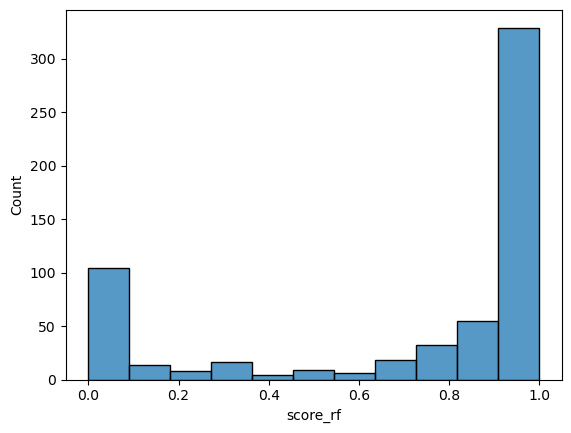

In [33]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [34]:
target_names = ['No fraude', 'Fraude']
print(classification_report(Y_c['target'], Y_c['preds_rf'], target_names=target_names))

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00  16724341
      Fraude       1.00      0.75      0.85       595

    accuracy                           1.00  16724936
   macro avg       1.00      0.87      0.93  16724936
weighted avg       1.00      1.00      1.00  16724936



In [35]:
Y_c['preds_rf'].value_counts()

preds_rf
False    16724490
True          446
Name: count, dtype: int64

In [36]:
Y_c.score_rf[Y_c['preds_rf']==True].min()

0.5075956304504394

In [37]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
#percentiles = pd.qcut(Y_c['score_rf'], q=10, duplicates='drop').astype(str)
percentiles = pd.qcut(Y_c['score_rf'], q=10, duplicates='drop')

percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA 30%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))

FRAUD CAPTURA 30%:
1.0


In [38]:
DECILES_T = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])

In [39]:
DECILES_T

target,False,True
FRAUD_DECILE,,
1,1671899,595
2,1672493,0
3,1672494,0
4,1672493,0
5,1672494,0
6,1672493,0
7,1672494,0
8,1672493,0
9,1672494,0


array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

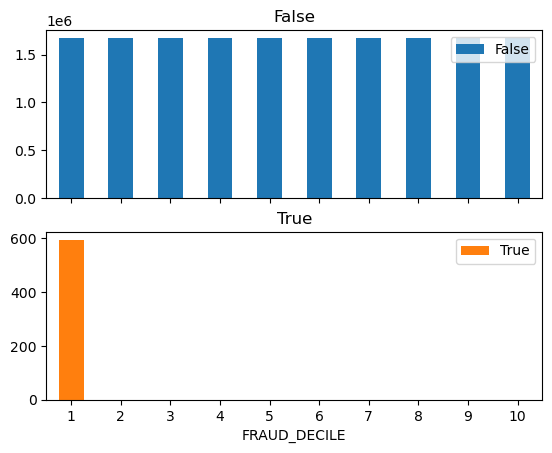

In [40]:
DECILES_T.plot.bar(stacked=False, rot=0,subplots=True)

In [41]:
#saco el punto de corte del primer centil para aplicarlo al test
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             3.116096e-10  1.000000e+00
2             9.099857e-11  3.116093e-10
3             4.068821e-11  9.099854e-11
4             2.128568e-11  4.068819e-11
5             1.192335e-11  2.128567e-11
6             6.789974e-12  1.192334e-11
7             3.761165e-12  6.789974e-12
8             1.897157e-12  3.761163e-12
9             7.410499e-13  1.897156e-12
10            5.201231e-15  7.410496e-13

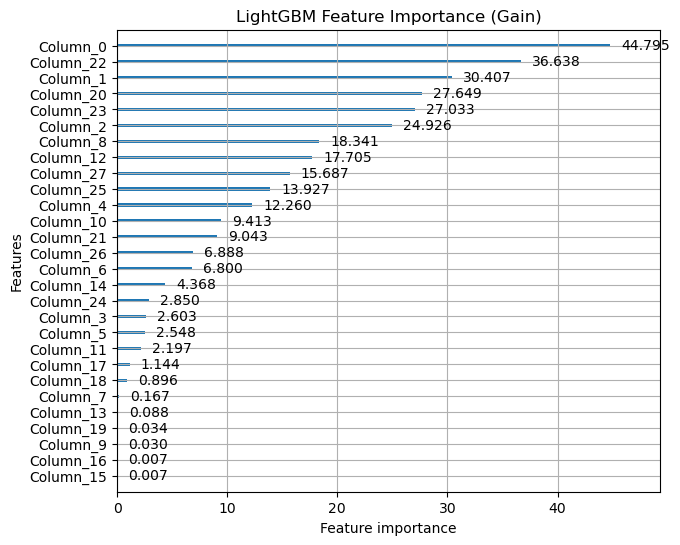

In [42]:
lgb.plot_importance(lgb_classifier, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

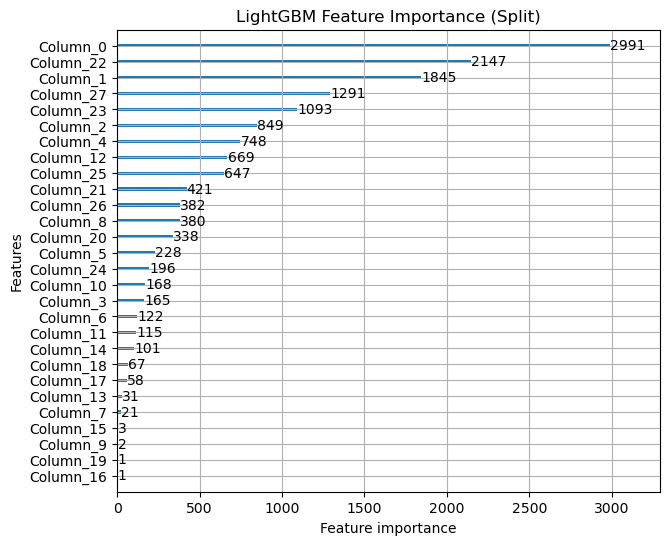

In [43]:
# Plot feature importance using Split
lgb.plot_importance(lgb_classifier, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

In [44]:
### Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
#classes = np.unique(Y_c[['target']])
#percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
#percentages = percentages[1:]
#gains = gains[1:]
#gains = gains / percentages
#indice = round(len(gains) * 0.1)
#print('LIFT INV CHURN TRAIN:')
#print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
#print('ROC INV CHURN TRAIN:')
#print(roc_auc_score(Y_c[['target']], Y_c['preds_rf']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
#thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'].ravel())
#print('KS INV CHURN TRAIN:')
#print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
#precision = precision_score(Y_c[['target']], Y_c['preds_rf'])
#recall = recall_score(Y_c[['target']], Y_c['preds_rf'])

#print('Precision INV CHURN TRAIN:')
#print(precision)
#print('Recall INV CHURN TRAIN:')
#print(recall)


In [86]:
import joblib
# save model
joblib.dump(lgb_classifier, 'ModeloV2TodosMenosVariables.pkl')
with open("./ModeloV2TodosMenosVariables.txt", "w") as output:
    output.write(str(var_input))
# load model
#gbm_pickle = joblib.load('ModeloV1T1.pkl')

In [85]:
# Guardando las importancias de las características (feature importance) en un archivo de texto
# La importancia se mide en términos de ganancia ('gain') según el clasificador LightGBM
np.savetxt('./ModeloV2TodosMenosVariablesImp.txt', lgb_classifier.booster_.feature_importance(importance_type='gain'),fmt='%f')

## TESTEO ##

In [47]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model"

tes = pd.read_parquet(f"s3://{s3_url}/TargetTodos/Test/Test.parquet")


In [48]:
## TARGETS de TESTE0
#target 1
tgt = tes['target']

In [49]:
##lista de variables de input
X = tes[var_input]
Y = tes['target'] 


In [50]:
testeo = tes

In [51]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
testeo = limpiar_nombres_columnas(testeo)

In [52]:
testeo = testeo
 
print ("Dataset Length: ", len(testeo)) 
print ("Dataset Shape: ", testeo.shape)

Dataset Length:  9754074
Dataset Shape:  (9754074, 80)


In [53]:
testeo['target'].value_counts(dropna=False)

target
False    9753910
True         164
Name: count, dtype: int64

In [54]:
## Variables del modelo
X_TESTEO = tes[var_input]

In [55]:
X_TESTEO

,branch_trans_3m,count_date_receiver_distinct,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_4min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_Var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
0,997,90,0,0,2,1,0,0,5,0,True,True,1.607143,False,False,False,False,False,True,0,0.089888,1.000000,0.233198,0.918367,0.000000,0.284932,0.495238,0.708333
1,351,85,0,0,1,1,1,0,7,0,False,True,0.626766,False,False,False,False,True,False,0,0.146067,1.000000,0.411405,0.255102,0.000000,0.271233,0.471429,0.666667
2,3801,92,0,0,4,1,1,0,1,0,True,True,1.000000,False,False,False,False,True,False,0,0.000000,1.000000,0.680244,0.120408,0.000000,0.295890,0.514286,0.541667
3,1261,87,0,0,1,1,1,0,1,0,True,True,1.000000,False,False,False,False,True,False,0,0.000000,0.000000,1.000000,0.512245,0.000000,0.128767,0.223810,0.458333
4,16206,92,0,0,34,9,6,0,7,0,False,False,1.473684,False,False,False,False,True,False,0,0.146067,1.000000,0.224033,1.000000,0.000000,0.230137,0.400000,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9754069,986,77,0,0,4,1,1,0,1,0,False,True,1.000000,False,False,False,False,True,False,0,0.000000,1.000000,0.918534,0.204082,0.000000,0.000000,0.000000,0.541667
9754070,6078,92,0,0,6,1,1,0,5,0,False,True,1.000000,False,False,False,False,True,False,0,0.011236,0.647727,1.000000,0.102041,0.000000,0.046575,0.080952,0.833333
9754071,1574,66,5,0,3,2,2,0,8,0,False,True,0.352268,False,True,False,False,True,False,0,0.539326,1.000000,1.000000,0.102041,0.000347,0.000000,0.000000,0.875000
9754072,1634,79,0,0,3,2,0,0,8,0,True,True,0.804204,False,False,False,False,False,True,0,0.370787,1.000000,1.000000,0.448980,0.000000,0.041096,0.071429,0.541667


In [56]:

# Extrayendo la columna 'target' del DataFrame 'testeo' y creando un nuevo DataFrame 'Y_TESTEO'
Y_TESTEO = pd.DataFrame(testeo['target'])

# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = lgb_classifier.predict(X_TESTEO)

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = lgb_classifier.predict_proba(X_TESTEO)

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [57]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_TESTEO_c = Y_TESTEO.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_TESTEO_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_TESTEO_c['score_rf'] = score_rf

Y_TESTEO_c['pred_corte'] = Y_TESTEO_c['score_rf']>corte

In [58]:
pd.DataFrame(confusion_matrix(Y_TESTEO_c['target'], Y_TESTEO_c['preds_rf']))

,0,1
0,9753905,5
1,157,7


In [59]:
pd.DataFrame(confusion_matrix(Y_TESTEO_c['target'], Y_TESTEO_c['pred_corte']))

,0,1
0,8855758,898152
1,8,156


In [78]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_TESTEO_c['score_rf'], q=10, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}

percentiles = percentiles.map(percentile_label)
Y_TESTEO_c['FRAUD_DECILE'] = np.nan
Y_TESTEO_c['FRAUD_DECILE'] = percentiles
Y_TESTEO_c['FRAUD_DECILE'] = Y_TESTEO_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA 30%:')
print(sum(Y_TESTEO_c[Y_TESTEO_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_TESTEO_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')

FRAUD CAPTURA 30%:
0.975609756097561


In [71]:
DECILES = pd.crosstab(Y_TESTEO_c['FRAUD_DECILE'], Y_TESTEO_c['target'])

In [72]:
DECILES

target,False,True
FRAUD_DECILE,,
10,975408,0
9,975407,0
8,975407,0
7,975408,0
6,975405,2
5,975405,2
4,975408,0
3,975405,2
2,975405,2


In [73]:
Y_TESTEO_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': ['min', 'max']}) 

/tmp/ipykernel_14016/3844416081.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Y_TESTEO_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': ['min', 'max']})


score_rf              
                       min           max
FRAUD_DECILE                            
10            5.978928e-15  4.751644e-13
9             4.751649e-13  1.242129e-12
8             1.242129e-12  2.507718e-12
7             2.507726e-12  4.597370e-12
6             4.597371e-12  8.215120e-12
5             8.215124e-12  1.500774e-11
4             1.500774e-11  2.966400e-11
3             2.966402e-11  7.013719e-11
2             7.013721e-11  2.671536e-10
1             2.671540e-10  9.999999e-01

array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

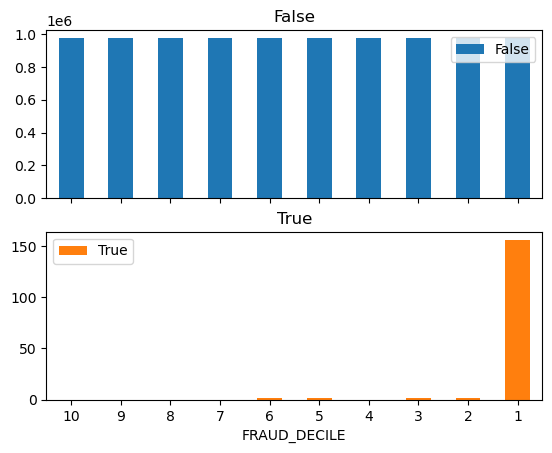

In [74]:
DECILES.plot.bar(stacked=False, rot=0,subplots=True)

In [65]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
#classes = np.unique(Y_TESTEO_c[['target']])
#percentages, gains = cumulative_gain_curve(Y_TESTEO_c[['target']], Y_TESTEO_c['score_rf'], classes[1])
#percentages = percentages[1:]
#gains = gains[1:]
#gains = gains / percentages
#indice = round(len(gains) * 0.1)
#print('LIFT INV CHURN TESTEO:')
#print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
#print('ROC INV CHURN TESTEO:')
#print(roc_auc_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
#thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_TESTEO_c[['target']], Y_TESTEO_c['score_rf'].ravel())
#print('KS INV CHURN TESTEO:')
#print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
#precision = precision_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf'])
#recall = recall_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf'])
#print('Precision INV CHURN TESTEO:')
#print(precision)
#print('Recall INV CHURN TESTEO:')
#print(recall)


In [66]:
#testeo_all10dec2023.to_csv('testeo_60Mx10dec2023.csv')